In [1]:
from nd2tif.transform import to_8bits

In [2]:
from nd2_combine import tools
from segment import seg
from droplet_growth import multiwell
import numpy as np
import logging
import os
import math
from skimage.transform import rotate
import json
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

In [3]:
PX_SIZE_UM = 1.6

In [4]:
fluo_path = '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC3/D5-BRA-PAX6.nd2'
assert os.path.exists(fluo_path)

In [5]:
dirr = fluo_path.replace('.nd2','')
try:
    os.mkdir(dirr)
except FileExistsError:
    pass

In [6]:
def to_rgb(stack, order):
    stack8 = stack#to_8bits(stack)
#     print(stack8.shape, stack8.dtype)
    ch = {'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}
    rgb = np.stack([stack8[order.index(v)] for v in ch.values()], axis=-1)
#     print(rgb.shape)
#     multiwell.show(rgb)
    

In [7]:
class MultiColorWell:
    def __init__(self, stack_cyx:np.ndarray, 
                 order:list, colors={'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}):
        stack = stack_cyx
        assert stack.ndim == 3
        self.original_stack = stack
        assert [color in order for color in colors.values()]
        stack_order = [order.index(v) for v in colors.values()]
        self.colors = colors
        self.rgb = np.stack(to_8bits(stack)[stack_order], axis=-1)
        
    def __repr__(self):
        multiwell.show(self.rgb)
        multiwell.plt.title(self.colors)
        multiwell.plt.show()
        return f'rgb {self.rgb.shape}'
                        
        
        

In [8]:
# from pims_nd2 import ND2_Reader as nd
from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = frames.metadata['channels']
        print(channels)
        px_size_um = frames.metadata['pixel_microns']
        frames.iter_axes = 'v'
        frames.default_coords['z'] = 0
        frames.bundle_axes = bundle_axes
#         if well_index is not None:
#             yield frames[well_index]
#         else:
        for f in frames:
            yield f#MultiColorWell(f, channels)

In [9]:
from pims_nd2 import ND2_Reader as nd
# from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = [
            frames.metadata[f'plane_{i}']['name'] for i in range(
                frames.sizes['c']
            )
        ]
        print(channels)
        px_size_um = frames.calibration
        frames.iter_axes = 'm'
        frames.bundle_axes = bundle_axes
        for f in frames:
            yield MultiColorWell(f, channels)

In [19]:
def filter_regions(r, maj_len=(500, 200), ecc=(0.4, 0.4), convex_area_tolerance=.1):
    return   (r.major_axis_length > maj_len[0] - maj_len[1] and 
              r.major_axis_length < maj_len[0] + maj_len[1] and
              r.eccentricity > ecc[0] - ecc[1] and
              r.eccentricity < ecc[0] + ecc[1] and
              r.convex_area - r.area < r.area * convex_area_tolerance
             )


def get_intensity(mask, intensity_image):
    props = multiwell.regionprops(
        mask,
        intensity_image=intensity_image
    )
#     print(f'MALs: {[p.major_axis_length for p in props]}')
#     print(f'eccs: {[p.eccentricity for p in props]}')
    f_props = list(filter(filter_regions, props))
    print(f'{len(f_props)} after filtering')
    return f_props


def decompose_RGB(rgb_stack):
    tritc = rgb_stack.rgb[:,:,0]
    fitc = rgb_stack.rgb[:,:,1]
    dapi = rgb_stack.rgb[:,:,2]
    return tritc, fitc, dapi
    

def segment_multichannel(rgb_stack:MultiColorWell):
    
    tritc, fitc, dapi = decompose_RGB(rgb_stack)
    
    segs = segment_bf(dapi, thr=0.15, smooth=10, erode=20)
    
    crops = map(lambda img: get_intensity(segs.mask, img), (tritc, fitc, dapi))
    
    fig, ax = multiwell.plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(rgb_stack.rgb)
    ax[1].imshow(segs.mask)
    multiwell.plt.show()
    
    result = {'channels': rgb_stack.colors,
              'profiles_axis': 'major_axis',
              'organoids': {}
             }

    for index, (r, g, b) in enumerate(zip(*crops)):
        
        rotated_crops = [rotate(
            props.intensity_image,
            -props.orientation / math.pi * 180 - 90,
#             center= r.local_centroid,
            resize=True
        ) for props in (r,g,b)]
        
        intensity_profiles = {color: {'mean': list(crop.mean(axis=0).astype('float16')),
                                 'max': list(crop.max(axis=0).astype('float16'))}
                            for crop,color in zip(
                                rotated_crops,
                                rgb_stack.colors.keys()
                            )
                        }
        
        result['organoids'][index] = {
            'centroid_yx': r.centroid,
#             'coords': list(r.coords),
            'major_axis_length': int(r.major_axis_length),
            'eccentricity': np.round(r.eccentricity, 2),
            'orientation': np.round(r.orientation, 2),
            'intensity_profiles': intensity_profiles,
        }
        
        print(f'MAL {r.major_axis_length}, ecc {r.eccentricity}')
        y0,x0 = r.local_centroid
        y,x = r.weighted_local_centroid
        
        fig, ax = multiwell.plt.subplots(1,4, figsize=(10,3), dpi=150)
        
        ax[0].imshow(b.intensity_image)
        plot_axes(r, ax[0])
        ax[0].plot(x0, y0, 'bx')
        ax[0].plot(x,y, 'rx')
        ax[0].set_title('DAPI')
               
        
        ax[1].imshow(np.stack(rotated_crops, axis=-1))
        ax[1].set_title('x-aligned')
        
        [ax[2].plot(
            crop.mean(axis=0)/crop.mean(axis=0).max(),
            fmt,
            label=color
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[2].legend()
        ax[2].set_title('x mean projection')
        
        [ax[3].plot(
            crop.max(axis=0)/crop.max(),
            fmt,
            label=color,
            lw=0.5
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[3].legend()
        ax[3].set_title('x max projection')
        
    return result
    
def plot_axes(props, ax):
    y0, x0 = props.local_centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
    ax.set_title(f'angle {orientation}')

#     minr, minc, maxr, maxc = props.bbox
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
#     ax.plot(bx, by, '-b', linewidth=2.5)

In [20]:
class SegmentedImage:
    
    def __init__(self, raw_image, mask, crop=None):
        self.raw_image = raw_image
        self.mask = mask
        self.crop=crop

In [21]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        multiwell.show(sm)
        multiwell.plt.show()
        multiwell.show(labels)
        multiwell.plt.show()
        
    return SegmentedImage(well, labels)


In [22]:
def choose_region(seg_image:SegmentedImage, diameter, diameter_tolerance, ecc=0, ecc_tolerance=0.3, plot=True):
    
    props_table = multiwell.regionprops_table(
        seg_image.mask, 
        intensity_image=seg_image.raw_image,
        properties=[
            'label', 
            'area', 
            'major_axis_length', 
            'eccentricity',
            'bbox',
            'intensity_image'
        ]
    )
    if plot:
        multiwell.plt.scatter(
            props_table['major_axis_length'], 
            props_table['eccentricity'], 
            s=props_table['area']/200
        )
        multiwell.plt.fill_between(
            x=(diameter-diameter_tolerance, diameter+diameter_tolerance),
            y1=ecc-ecc_tolerance,
            y2=ecc+ecc_tolerance,
            alpha=.3
        )
        multiwell.plt.xlabel('major axis length, px')
        multiwell.plt.ylabel('eccentricity')
        
        multiwell.plt.show()
    
    diam = props_table['major_axis_length']
    mask1 = abs(diam - diameter) < diameter_tolerance
    ecc_vector = props_table['eccentricity']
    mask2 = abs(ecc_vector - ecc) < ecc_tolerance
    mask = np.logical_and(mask1, mask2)
    labels = props_table['label']
    reg_label = labels[mask]
    if len(reg_label) > 1: 
        print(f'expected one region, got labels: {reg_label}. Selecting biggest area')
        reg_label = reg_label[np.argmax(props_table['area'][mask])]
    elif len(reg_label) == 0:
        raise IndexError('No regions found within limits')
        
    print(f'selected region {reg_label}')
    well_crop = props_table['intensity_image'][props_table['label'] == reg_label][0]
    if plot:
        multiwell.show(well_crop)
        
    return SegmentedImage(
        seg_image.raw_image, 
        mask = seg_image.mask == reg_label, 
        crop=well_crop
    )

In [23]:
def segment_organoid(masked_image:SegmentedImage, thr=0.2, smooth=10, erode=100, plot=True):
    mask = masked_image.mask
    img = masked_image.raw_image
    
    er_mask = multiwell.binary_erosion(mask, iterations=erode)
    
    grad = multiwell.get_2d_gradient(img)
    sm = multiwell.gaussian_filter(grad, smooth)
    
    regions = sm > thr * sm.max()
    
    er_regions = regions * er_mask
    
    f_regions = multiwell.binary_fill_holes(er_regions)
    
    if plot:
#         multiwell.show(regions)
#         multiwell.plt.show()

        multiwell.show(regions * er_mask)
        multiwell.plt.show()
        
    
    return SegmentedImage(img, multiwell.label(f_regions)[0])

In [24]:
def get_organoid(bf_frame, plot=False):
    well = choose_region(
        segment_bf(bf_frame, thr=0.1, erode=50, smooth=10, fill=True, plot=plot),
        diameter=1200,
        diameter_tolerance=200,
        ecc=.2,
        ecc_tolerance=.2,
        plot=plot
    )
    organoid = choose_region(
        segment_organoid(well, thr=0.2, smooth=5, erode=100, plot=plot),
        diameter=200,
        diameter_tolerance=150,
        ecc=0.5,
        ecc_tolerance=0.4,
        plot=plot
    )
    return organoid

In [25]:
well = read_nd2(fluo_path, bundle_axes='cyx', well_index=None, )

In [26]:
# w = next(well)

/Users/andrey/miniconda3/envs/nd2/lib/python3.8/site-packages/pims/base_frames.py:522: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


{'x': 2048, 'y': 2044, 'c': 4, 'm': 19}
['DaFiTr', 'FITC', 'TRITC', 'DAPI']
Field of view 1
1 regions


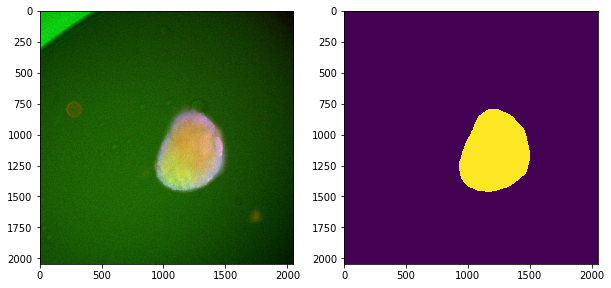

1 after filtering
1 after filtering
1 after filtering
MAL 678.310031017054, ecc 0.5939417537126882
Field of view 2
1 regions


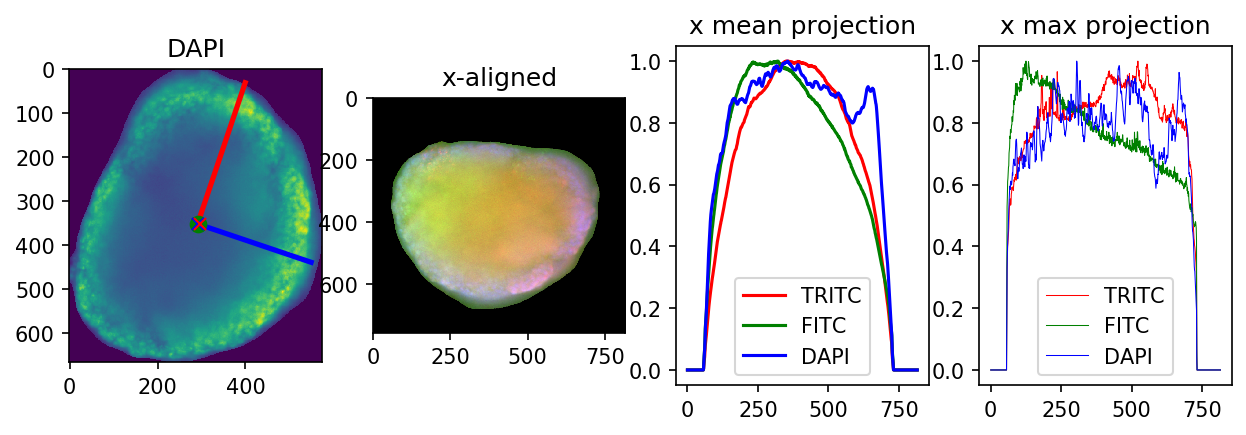

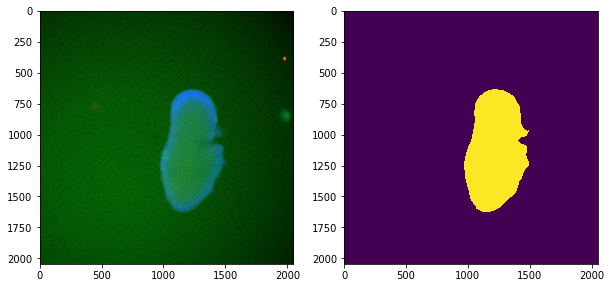

0 after filtering
0 after filtering
0 after filtering
Field of view 3
2 regions


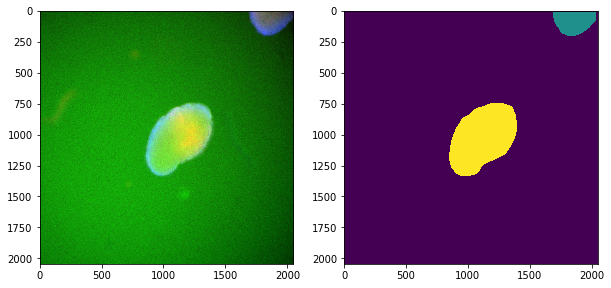

1 after filtering
1 after filtering
1 after filtering
MAL 687.761812716841, ecc 0.7873890445372975
Field of view 4
2 regions


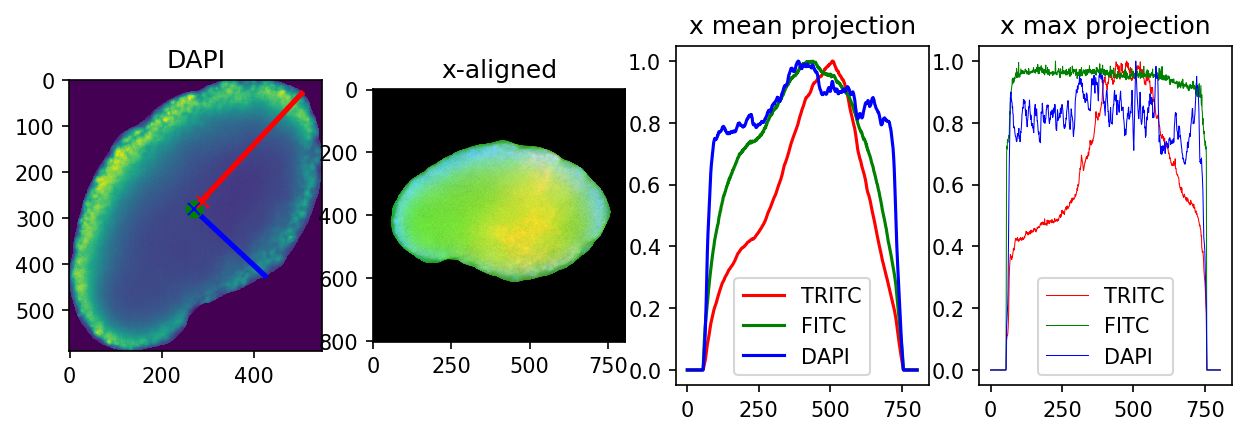

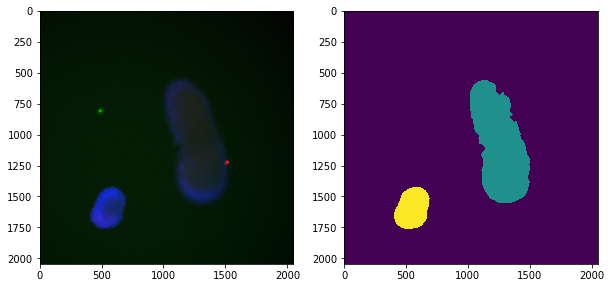

1 after filtering
1 after filtering
1 after filtering
MAL 364.7127829409318, ecc 0.6965718988595603
Field of view 5
2 regions


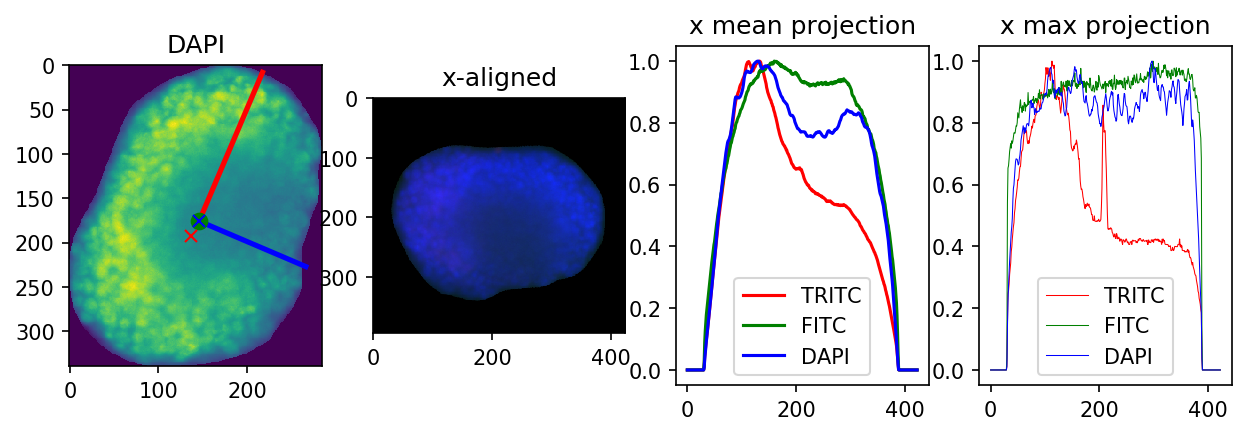

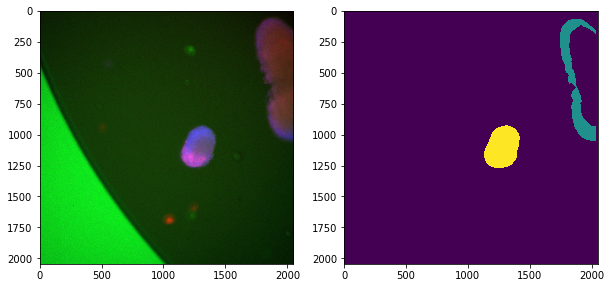

1 after filtering
1 after filtering
1 after filtering
MAL 367.7841978056371, ecc 0.6945345357473964
Field of view 6
4 regions


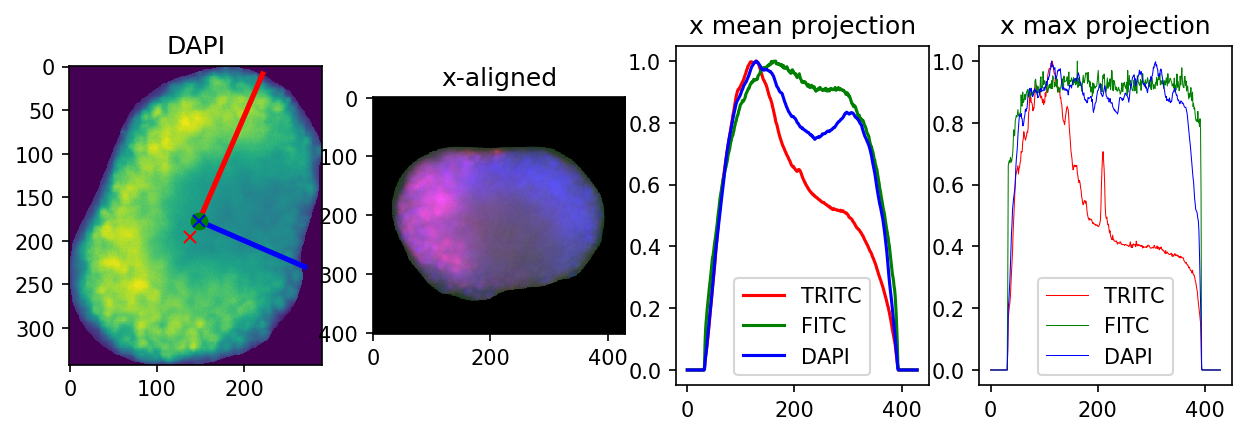

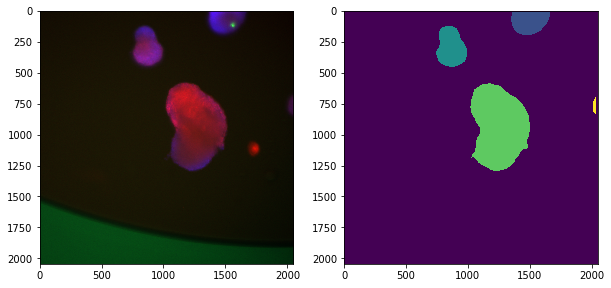

2 after filtering
2 after filtering
2 after filtering
MAL 319.50162989245655, ecc 0.796812547308307
MAL 344.42551666974464, ecc 0.729884713469039
Field of view 7
3 regions


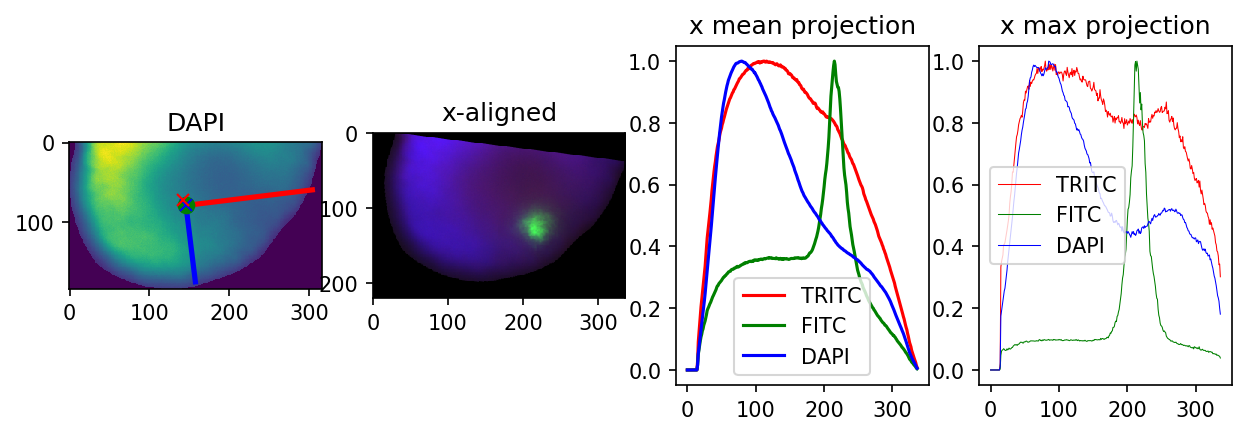

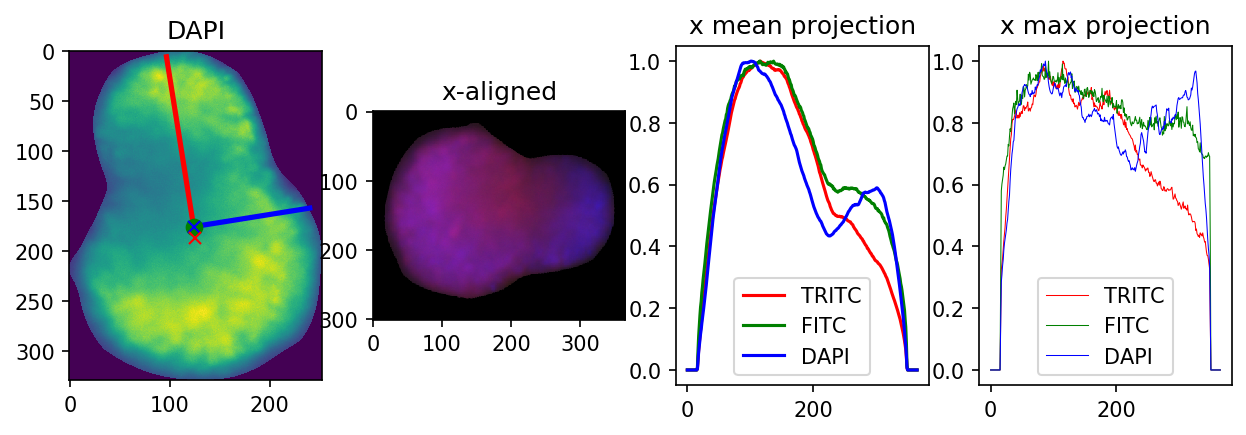

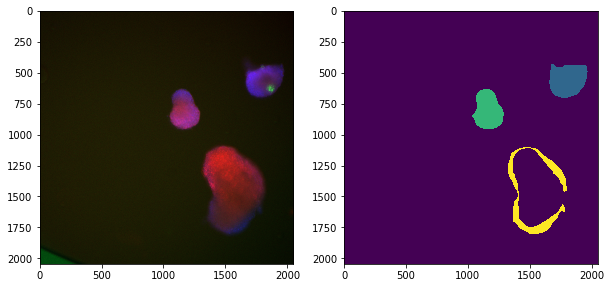

2 after filtering
2 after filtering
2 after filtering
MAL 331.4776020839354, ecc 0.5808601132985028
MAL 338.1187686459682, ecc 0.727944323152308
Field of view 8
4 regions


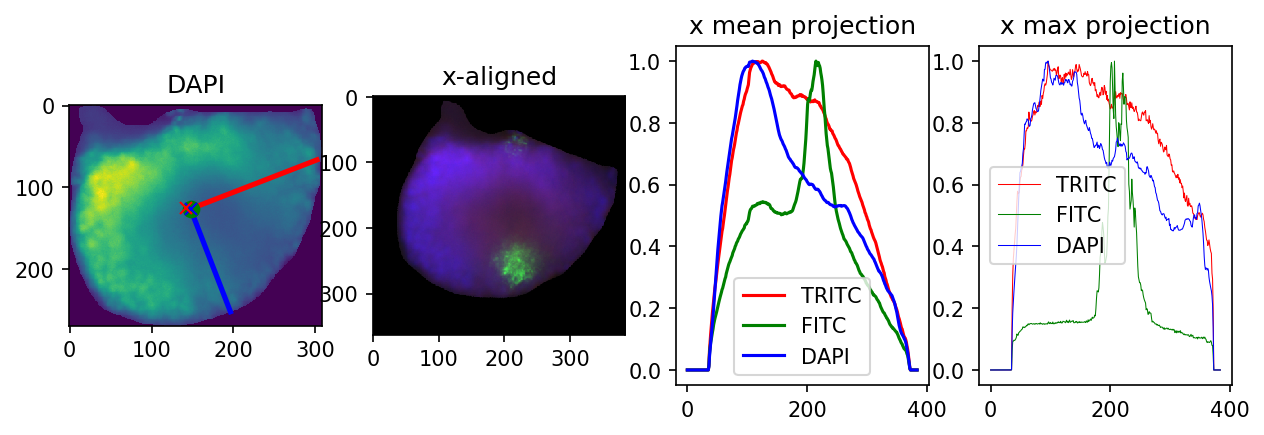

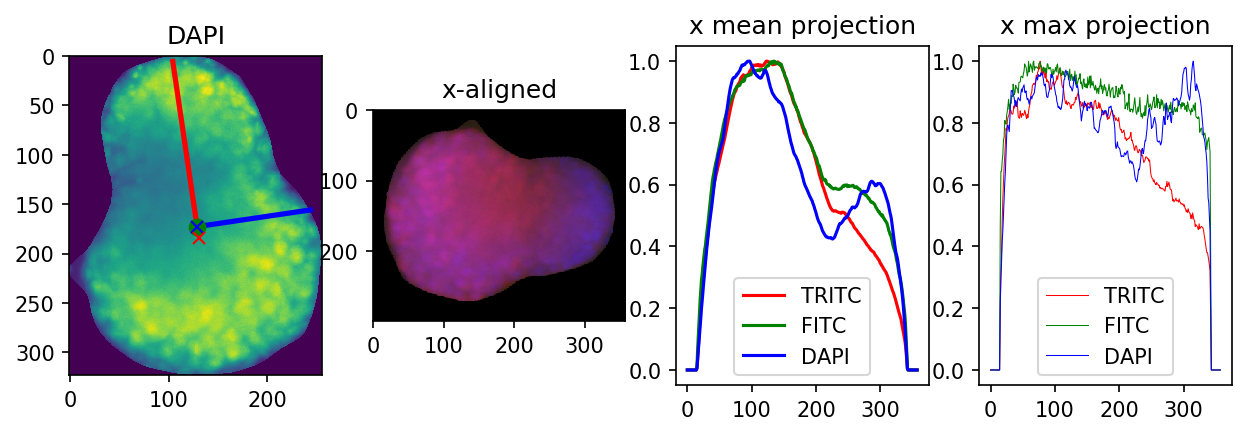

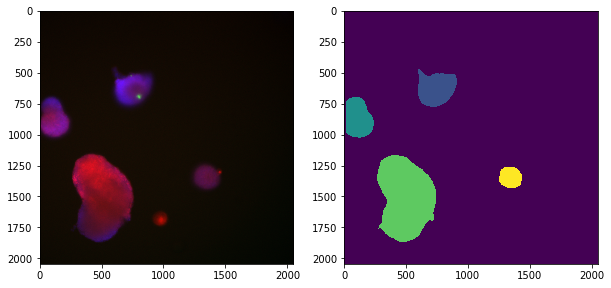

2 after filtering
2 after filtering
2 after filtering
MAL 338.2154820121188, ecc 0.5411960275245127
MAL 346.6344782862821, ecc 0.7718949825322589
Field of view 9
2 regions


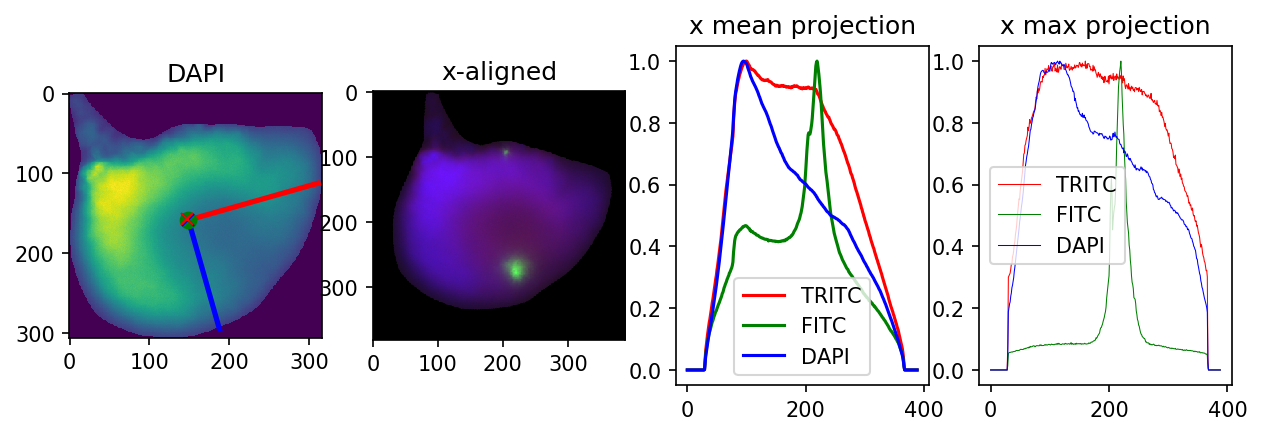

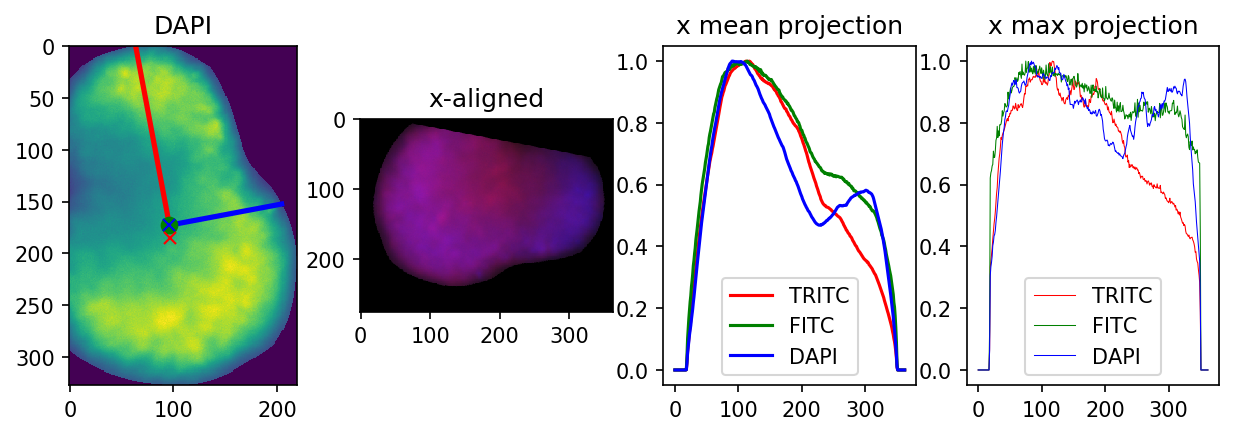

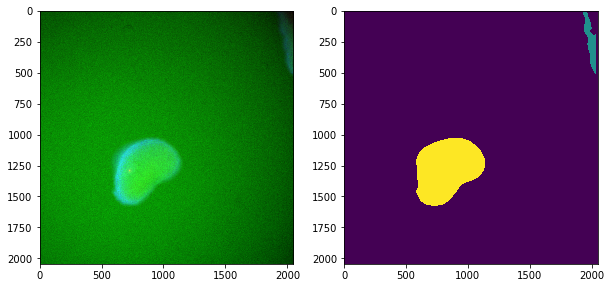

1 after filtering
1 after filtering
1 after filtering
MAL 633.2276431942278, ecc 0.6906959031861911
Field of view 10
8 regions


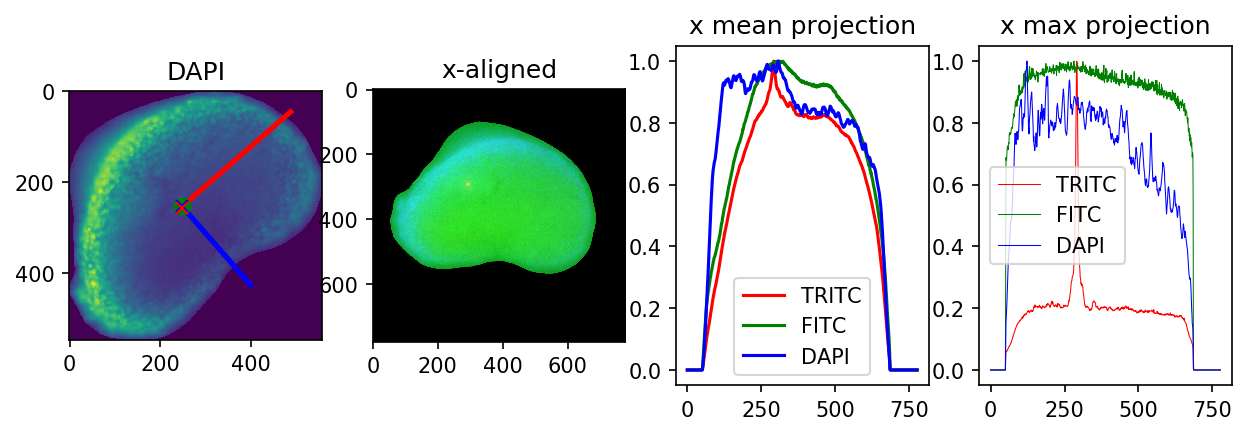

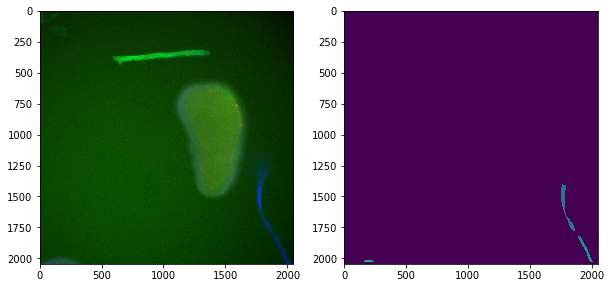

0 after filtering
0 after filtering
0 after filtering
Field of view 11
1 regions


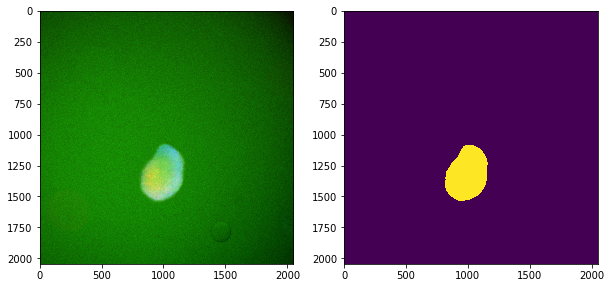

1 after filtering
1 after filtering
1 after filtering
MAL 465.59319274875304, ecc 0.7240965443860753
Field of view 12
9 regions


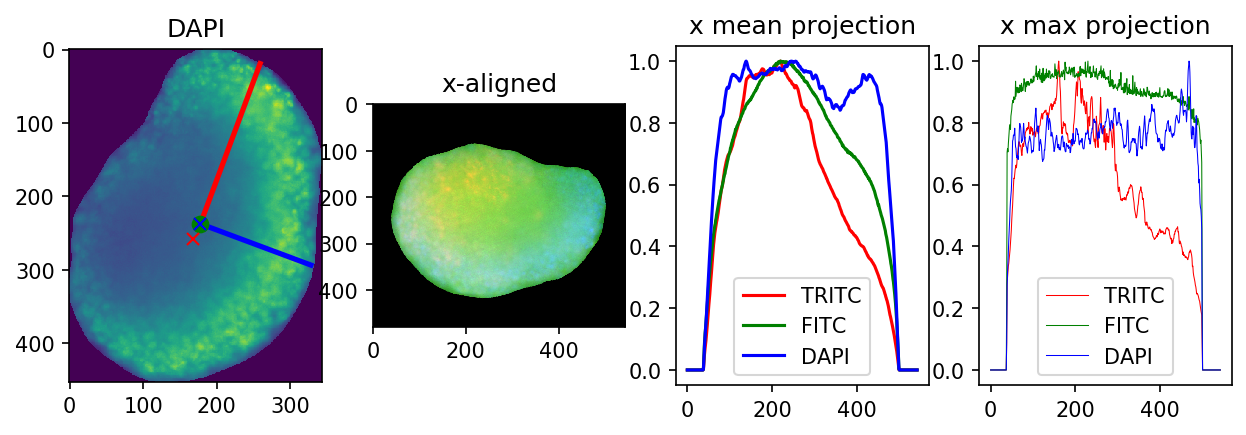

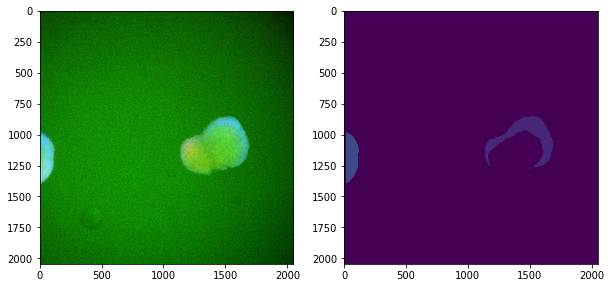

0 after filtering
0 after filtering
0 after filtering
Field of view 13
4 regions


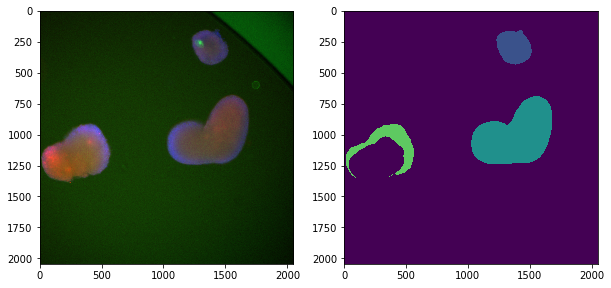

1 after filtering
1 after filtering
1 after filtering
MAL 302.13082098718445, ecc 0.5168161851459595
Field of view 14
3 regions


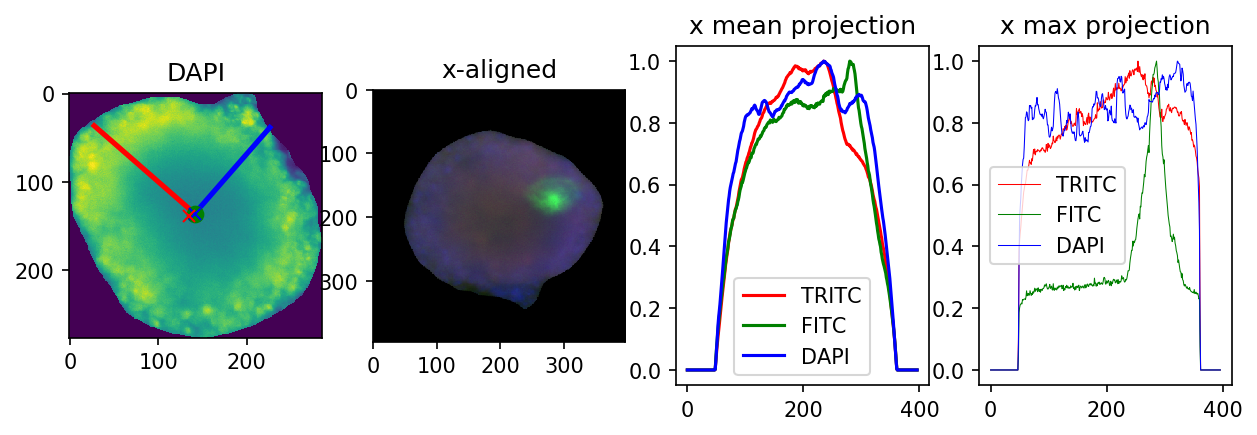

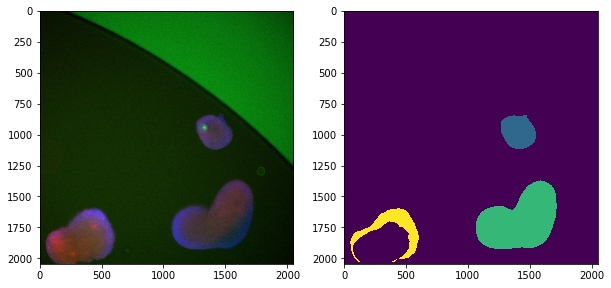

1 after filtering
1 after filtering
1 after filtering
MAL 302.9632462517994, ecc 0.5225362332677157
Field of view 15
4 regions


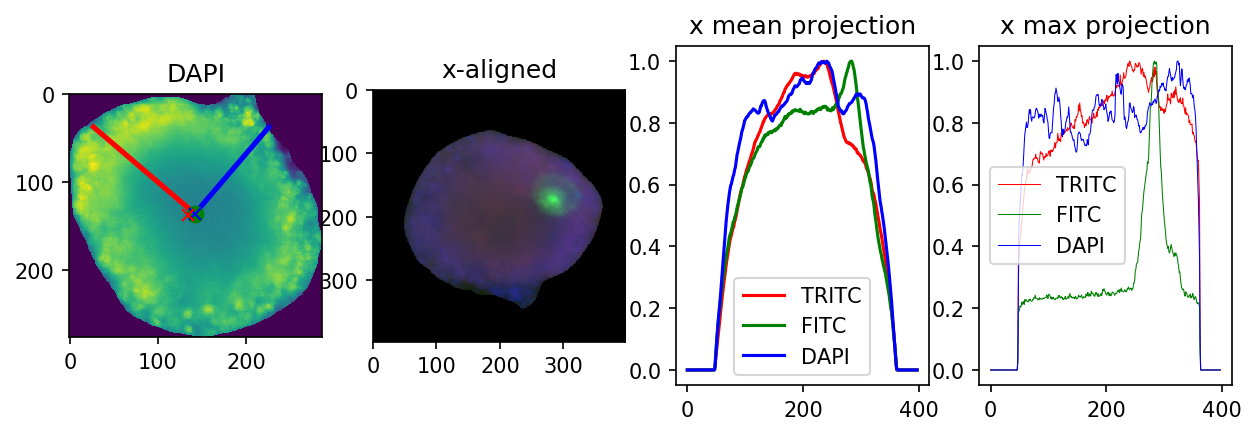

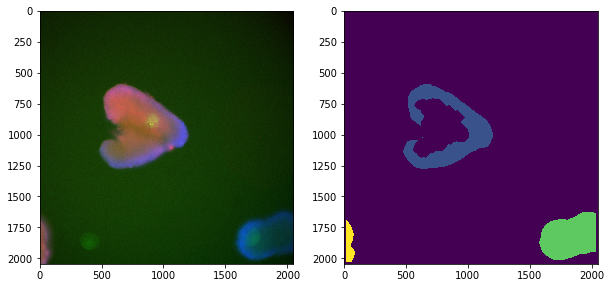

1 after filtering
1 after filtering
1 after filtering
MAL 511.9758914179407, ecc 0.728125236716207
Field of view 16
3 regions


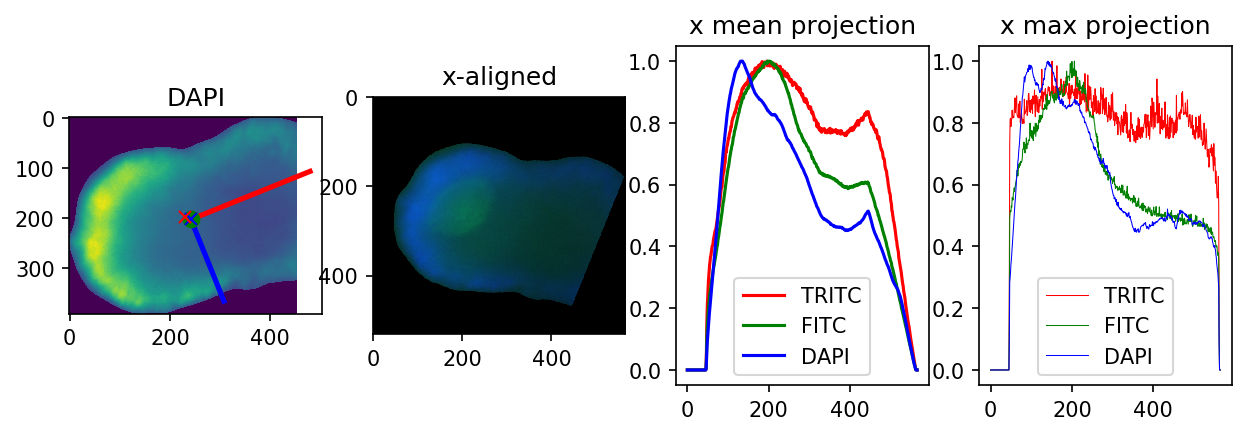

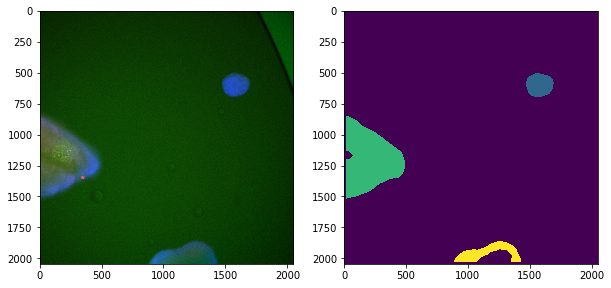

1 after filtering
1 after filtering
1 after filtering
MAL 594.1420208710126, ecc 0.5617897643091698
Field of view 17
3 regions


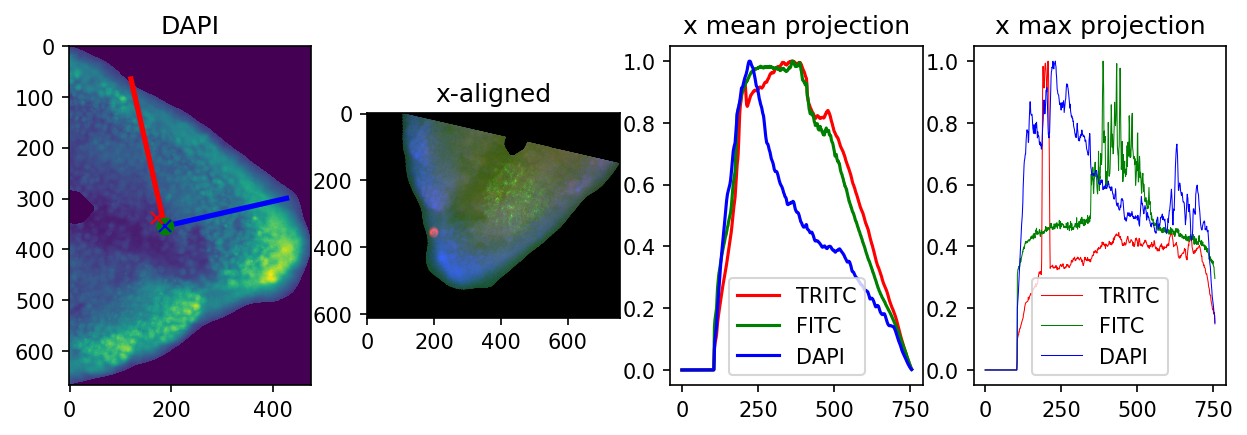

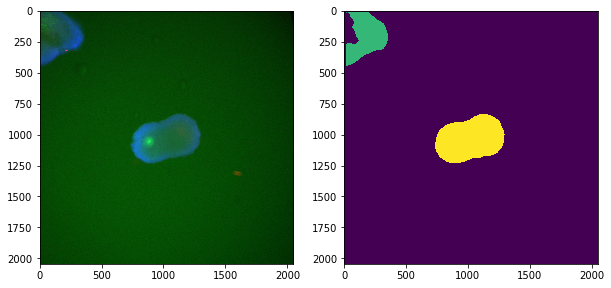

0 after filtering
0 after filtering
0 after filtering
Field of view 18
4 regions


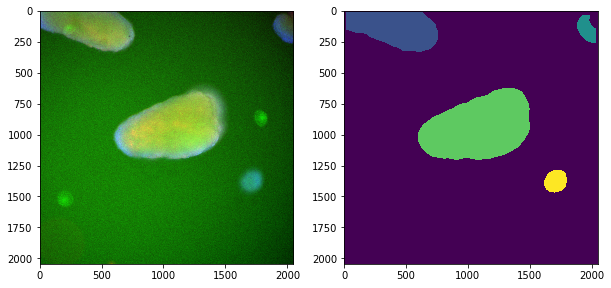

0 after filtering
0 after filtering
0 after filtering
Field of view 19
3 regions


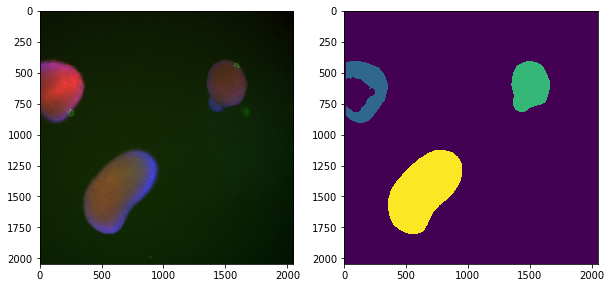

1 after filtering
1 after filtering
1 after filtering
MAL 411.0789099469546, ecc 0.6433390735846607


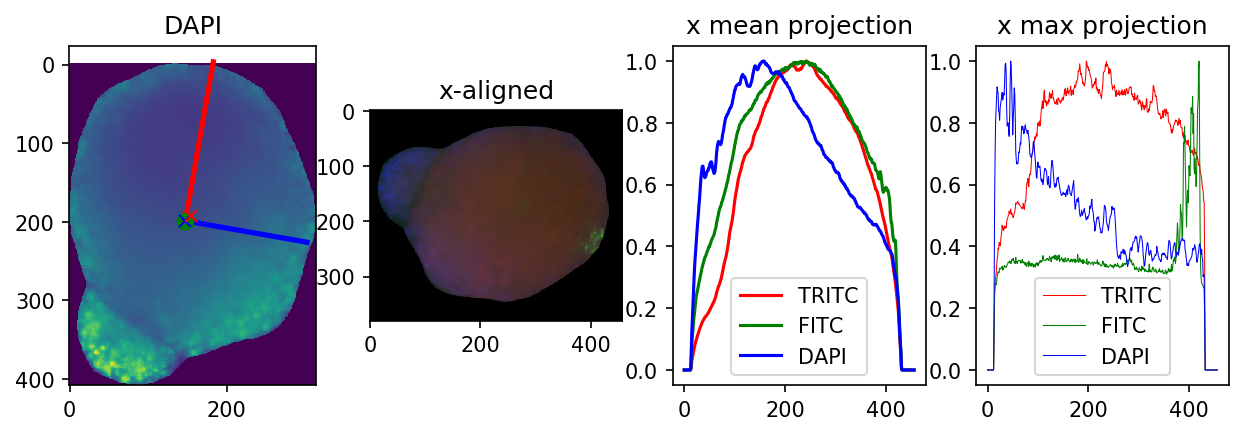

In [27]:
result = {'FOVs': {}}
for i, w in enumerate(well):
    print(f'Field of view {i+1}')
    result['FOVs'][i] = segment_multichannel(w)


In [336]:
import json

def convert(o):
    if isinstance(o, np.float16):
        return float(o)
    else:
        return 0
with open(fluo_path.replace('.nd2', '_profiles.json'), 'w') as fp:
    json.dump(result, fp, default=convert)

In [337]:
result_8001 = json.load(open(fluo_path.replace('.nd2', '_profiles.json')))

In [30]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d as gf

def subsample_intensity_profile(values, n_samples=10, sigma=10, plot=False):
    '''
    Subsamples 1D curve.
    1. Cut off zero values
    2. Smooth with `sigma`
    3. Intepolate using vector with `n_samples` spots
    
    Return:
    -------
    Subsampled values
    '''
    r_profile = np.array(values, 'float')
    rf_profile = r_profile[r_profile > 0]
    rfs_profile = gf(rf_profile, sigma)
    full_vector = np.arange(len(rfs_profile))
    approx = interp1d(full_vector, rfs_profile)
    vector = np.linspace(0, len(rfs_profile)-1, n_samples, endpoint=True)
    subsample = approx(vector)
    
    if plot:
        plt.plot(rf_profile)
        plt.plot(rfs_profile)
        plt.plot(vector, subsample, '.r')
    
    return subsample

In [31]:
subsample_intensity_profile(r_profile, plot=1)

NameError: name 'r_profile' is not defined

In [33]:
def orient(curve, color):
    curve = curve / curve.max()
    mid = len(curve) // 2
    if color == 'r':
        if curve.argmax() < mid:
            return curve[::-1], 'm'
        return curve, 'm'
    elif color == 'g':
        if curve.argmax() > mid:
            return curve[::-1], 'c'
        return curve, 'c'
    else:
        raise ValueError(f'expected color "r" or "g", got {color}')

In [34]:
binned_profiles = [{c: orient(subsample_intensity_profile(o['intensity_profiles'][c]['max'], n_samples=21), c)[0] for c in 'rg'} 
                   for f in result['FOVs'].values() 
                   for o in f['organoids'].values() 
                  ]

In [140]:
# binned_profiles

In [37]:
import pandas as pd

def _to_channel(color):
    if color == 'r':
        return 'TRITC'
    elif color == 'g':
        return 'FITC'
    else:
        raise ValueError(f'r or g only, got {color}')

def to_df(index, color, vector, curve, prefix=''):
    l = len(vector)
    assert (l := len(vector)) == len(curve)
    df = pd.DataFrame(data={'id': f'{prefix}_{index}', 'color': _to_channel(color), 'major axis': vector, 'normalized intensity': curve})
    return df

In [38]:
def get_vector(curve):
    return np.linspace(-0.5, 0.5, num=len(curve))

In [39]:
def profile_to_df(index:int, color_profile:dict, prefix=None):
    dfs = []
    for c, profile in color_profile.items():
        dfs.append(to_df(index, c, get_vector(profile), profile, prefix))
    return pd.concat(dfs)

In [70]:
from functools import reduce
dfs_3001 = reduce(lambda a, b: pd.concat([a,b], ignore_index=True), map(lambda bp: profile_to_df(*bp, prefix='3001'), enumerate(binned_profiles)))

In [71]:
dfs_3001

id  color  major axis  normalized intensity
0     3001_0  TRITC       -0.50              0.421870
1     3001_0  TRITC       -0.45              0.578272
2     3001_0  TRITC       -0.40              0.740835
3     3001_0  TRITC       -0.35              0.850468
4     3001_0  TRITC       -0.30              0.907268
..       ...    ...         ...                   ...
751  3001_17   FITC        0.30              0.260647
752  3001_17   FITC        0.35              0.257717
753  3001_17   FITC        0.40              0.247422
754  3001_17   FITC        0.45              0.203823
755  3001_17   FITC        0.50              0.138514

[756 rows x 4 columns]

In [56]:
def label_protein(df, color_column='color', 
                  color_protein_pairs={'TRITC': 'FOXA2', 'FITC': 'PAX-6'}
):
    proteins = [color_protein_pairs[c] for c in df[color_column]]
    dfp = df.copy()
    dfp['protein'] = proteins
    return dfp

In [72]:
dfs_3001 = label_protein(dfs_3001)

In [73]:
dfs_3001

id  color  major axis  normalized intensity protein
0     3001_0  TRITC       -0.50              0.421870   FOXA2
1     3001_0  TRITC       -0.45              0.578272   FOXA2
2     3001_0  TRITC       -0.40              0.740835   FOXA2
3     3001_0  TRITC       -0.35              0.850468   FOXA2
4     3001_0  TRITC       -0.30              0.907268   FOXA2
..       ...    ...         ...                   ...     ...
751  3001_17   FITC        0.30              0.260647   PAX-6
752  3001_17   FITC        0.35              0.257717   PAX-6
753  3001_17   FITC        0.40              0.247422   PAX-6
754  3001_17   FITC        0.45              0.203823   PAX-6
755  3001_17   FITC        0.50              0.138514   PAX-6

[756 rows x 5 columns]

In [74]:
dfs_3001.to_csv(fluo_path.replace('.nd2', '_binned_profiles.csv'), index=None)

In [75]:
dfs_3001.to_json(fluo_path.replace('.nd2', '_binned_profiles.json') )

In [76]:
dfs_8001 = pd.read_json('/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/8001_binned_profiles.json')

In [77]:
dfs_1_2 = pd.read_json('/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/1-2_binned_profiles.json')

In [89]:
dfs_3001 = pd.read_json('/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/3001_binned_profiles.json')

In [78]:
dfs_1_2_8001 = pd.concat([dfs_1_2, dfs_8001], ignore_index=True)

In [79]:
dfs_1_2_8001 = label_protein(dfs_1_2_8001, color_protein_pairs={'TRITC': 'BRA', 'FITC': 'PAX-6'})

In [90]:
dfs_all = pd.concat([dfs_1_2_8001, dfs_3001], ignore_index=True)

In [44]:
import seaborn as sns

Text(0.5, 1.0, '1-2, 3001, 8001')

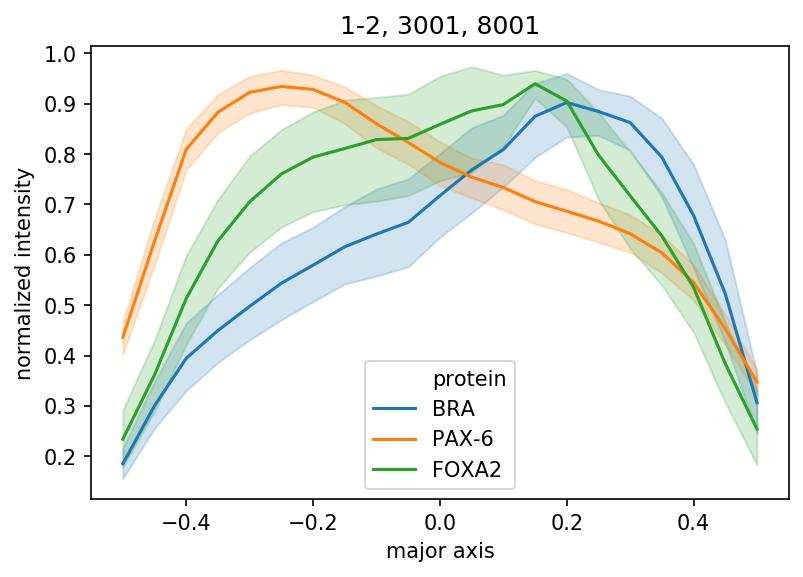

In [97]:
fig, ax = plt.subplots(dpi=150, facecolor='w')
sns.lineplot(ax=ax, x='major axis', y='normalized intensity', hue='protein', data=dfs_all)
plt.title('1-2, 3001, 8001')


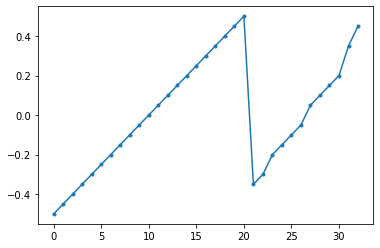

In [88]:
plt.plot(dfs_all['major axis'].unique(), '.-')

Text(0.5, 1.0, '`1-2` + `8001`, 16 samples')

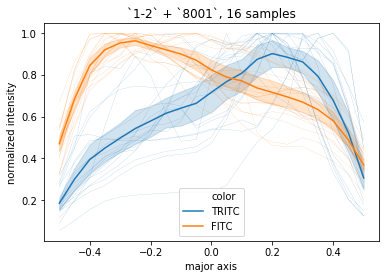

In [409]:
sns.lineplot(x='major axis', y='normalized intensity', hue='color', units='id', data=dfs_both, estimator=None, lw=.1,)
sns.lineplot(x='major axis', y='normalized intensity', hue='color',data=dfs_both, legend=None)
plt.title('`1-2` + `8001`, 16 samples')

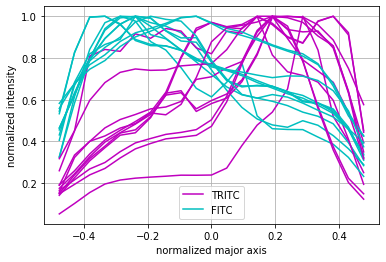

In [410]:
_ = [plt.plot((np.arange(len(p)) - len(p) // 2) / len(p) , *orient(p, c)) for bp in binned_profiles[1:] for c, p in bp.items() ]
plt.xlabel('normalized major axis')
plt.ylabel('normalized intensity')
plt.legend(['TRITC', 'FITC'])
plt.grid()

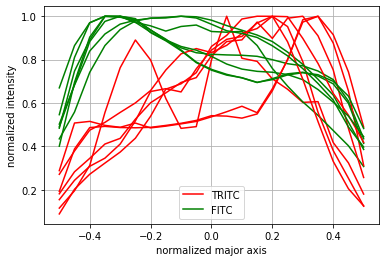

In [411]:
for bp in binned_profiles_8001[:]:
    for c, p in bp.items():
        try:
            _ = plt.plot(get_vector(p) , p, c) 
        except Exception as e:
            print(get_vector(p) , p, c)
            raise(e)
plt.xlabel('normalized major axis')
plt.ylabel('normalized intensity')
plt.legend(['TRITC', 'FITC'])
plt.grid()